# Машинное обучение

# Практическое задание по EM-алгоритму

## Общая информация

ФИО: Иванов Сергей Максимович

Группа: 317

Дата сдачи: 07.05.2017

### О задании

Практическое задание посвящено EM-алгоритму и его использовании в задачах классификации. В рамках данного задания вы:
 * научитесь моделировать данные, сгенерированные из распределений сложной природы;
 * реализуете ЕМ-алгоритм для 2 различных моделей генерации данных;
 * изучите поведение оценок параметров распределений и скрытых переменных в процессе ЕМ-алгоритма;
 * научитесь использовать ЕМ-алгоритм как метод обучения с учителем.
 

# EM-алгоритм

## Бинарная последовательность

Пусть наблюдается выборка бинарных значений $\mathbb{Y} = (y_1,\ldots, y_l), \; y_i\in\{0,1\}$. Все элементы выборки генерируются независимо, но известно, что в некоторый момент $z$ меняется частота генерации единиц, т.е.:
$$\mathbb{P}(y_i = 1) = 
\begin{cases}
\theta_1, \, i < z,\\
\theta_2, \, i \ge z. 
\end{cases}$$

В рамках данной части задания вам необходимо будет реализовать ЕМ-алгоритм для данной модели, где $z$–скрытая переменная, а $\theta_1, \theta_2$ – параметры распределения.

1\. **(1 балл)** Выведите формулы Е- и М-шагов алгоритма для заданной модели. Напомним, что результатом Е-шага является распределение скрытых переменных $q(z)$, М-шага — оценки на параметры распределения.

**E-шаг**.

Фиксируем $\theta_1$, $\theta_2$. Оцениваем правдоподобие для $z$:

$$L = \prod_i{\mathbb{P}(y_i = 1)^{y_i}\mathbb{P}(y_i = 0)^{1 - y_i}} \to max$$

$$\ln L = \sum_i{y_i \ln \mathbb{P}(y_i = 1) + (1 - y_i) \ln \mathbb{P}(y_i = 0)} = \sum_{i < z}{(y_i \ln{\theta_1} + (1 - y_i) \ln{(1 - \theta_1)})} + \sum_{i \ge z}{(y_i \ln{\theta_2} + (1 - y_i)\ln{(1 - \theta_2)})} \to \max_z$$

$$\mathbb{P}(z = \hat{z}) \propto \exp \Bigg[ \sum_{i < \hat{z}}{(y_i \ln \theta_1 + (1 - y_i) \ln (1 - \theta_1))} + \sum_{i \ge \hat{z}}{(y_i \ln \theta_2 + (1 - y_i) \ln (1 - \theta_2))}\Bigg]$$


**М-шаг**.

$$L_{z = \hat{z}} = \prod_i{\mathbb{P}(y_i = 1\ |\ z = \hat{z})^{y_i}\mathbb{P}(y_i = 0\ |\ z = \hat{z})^{1 - y_i}} \to max$$

$$\ln L_{z = \hat{z}} = \sum_i{y_i \ln \mathbb{P}(y_i = 1\ |\ z = \hat{z}) + (1 - y_i) \ln \mathbb{P}(y_i = 0\ |\ z = \hat{z})}  = \sum_{i < \hat{z}}{(y_i \ln \theta_1 + (1 - y_i) \ln (1 - \theta_1))} + \sum_{i \ge \hat{z}}{(y_i \ln \theta_2 + (1 - y_i) \ln (1 - \theta_2))} \to \max_{\theta_1, \theta_2} \iff
\begin{cases}
\sum_{i < \hat{z}}{(y_i \ln \theta_1 + (1 - y_i) \ln (1 - \theta_1))} \to \max_{\theta_1}\\
\sum_{i \ge \hat{z}}{(y_i \ln \theta_2 + (1 - y_i) \ln (1 - \theta_2))} \to \max_{\theta_2} 
\end{cases}$$

Для фиксированного $\hat{z}$:
$$\theta_1 = \frac{\sum_{i < \hat{z}}{y_i}}{\hat{z}}$$
$$\theta_2 = \frac{\sum_{i \ge \hat{z}}{y_i}}{l - \hat{z}}$$

Усредняем по всем $\hat{z}$ с вероятностями из E-шага:
$$\theta_1 = \sum_{\hat{z}}^l{\mathbb{P}(z = \hat{z})\frac{\sum_{i < \hat{z}}{y_i}}{\hat{z}}}=\sum_i{y_i \sum_{\hat{z} \ge i}{\frac{\mathbb{P}(z = \hat{z})}{\hat{z}}}}$$
$$\theta_2 = \sum_{\hat{z}}^l{\mathbb{P}(z = \hat{z})\frac{\sum_{i \ge \hat{z}}{y_i}}{l - \hat{z}}}=\sum_i{y_i \sum_{\hat{z} < i}{\frac{\mathbb{P}(z = \hat{z})}{l - \hat{z}}}}$$

2\. **(2 балла)** Реализуйте ЕМ-алгоритм для заданной модели в виде функции, параметром которой является наблюдаемая выборка, а возвращаемым значением — векторы с оценками параметров распределений на каждой итерации алгоритма. В качестве критерия останова можете использовать ограничение количества итераций. Формат входных и выходных данных функции остаётся на ваше усмотрение.

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
def EM(X, iterations=20):
    # вычисление функционала (удобно!):
    def Likelihood(z, t1, t2):
        return math.exp((X * math.log(t1) + (1 - X) * math.log(1 - t1))[:z.argmax()].sum() + (X * math.log(t2) + (1 - X) * math.log(1 - t2))[z.argmax():].sum())
    
    # инициализация
    L = len(X)
    z = np.random.uniform(0, 1, L)
    z /= z.sum()
    t1 = np.random.uniform(0, 1)
    t2 = np.random.uniform(0, 1)
    
    # хранение ответа в зависимости от итерации
    ans_z = [z]
    ans_t1 = [t1]
    ans_t2 = [t2]
    ans_f = [Likelihood(z, t1, t2)]
    
    for iteration in range(iterations):
        # E-шаг
        z = np.exp(np.cumsum(X * math.log(t1) + (1 - X) * math.log(1 - t1)) + np.cumsum((X * math.log(t2) + (1 - X) * math.log(1 - t2))[::-1])[::-1])
        z /= z.sum()
        
        # M-шаг
        t1 = (X * np.cumsum((z / (np.arange(L) + 1))[::-1])[::-1]).sum()
        t2 = (X * np.cumsum(z / (L - np.arange(L)))).sum()
        
        # вычислительные проблемы (вылет t1 или t2 к предельным значениям) возникали достаточно редко
        # поэтому вместо регуляризации показалось разумнее делать перезапуск
        if math.isnan(t1):
            return EM(X, iterations)
        
        # сохранение ответа
        ans_z.append(z)
        ans_t1.append(t1)
        ans_t2.append(t2)
        ans_f.append(Likelihood(z, t1, t2))
    
    return ans_z, ans_t1, ans_t2, ans_f

3\. **(0.5 балла)** Проведите эксперимент для $\theta_1 = 0.1$, $\theta_2 = 0.9, z=50, l=100.$ Для этого выполните следующие действия:
- сгенерируйте выборку для заданных истинных значений $\theta_1, \theta_2, z, l$;
- примените реализованную в п. 2 функцию;
- постройте графики зависимостей оценок $\theta_1, \theta_2, z$ от номера итерации ЕМ-алгоритма. 

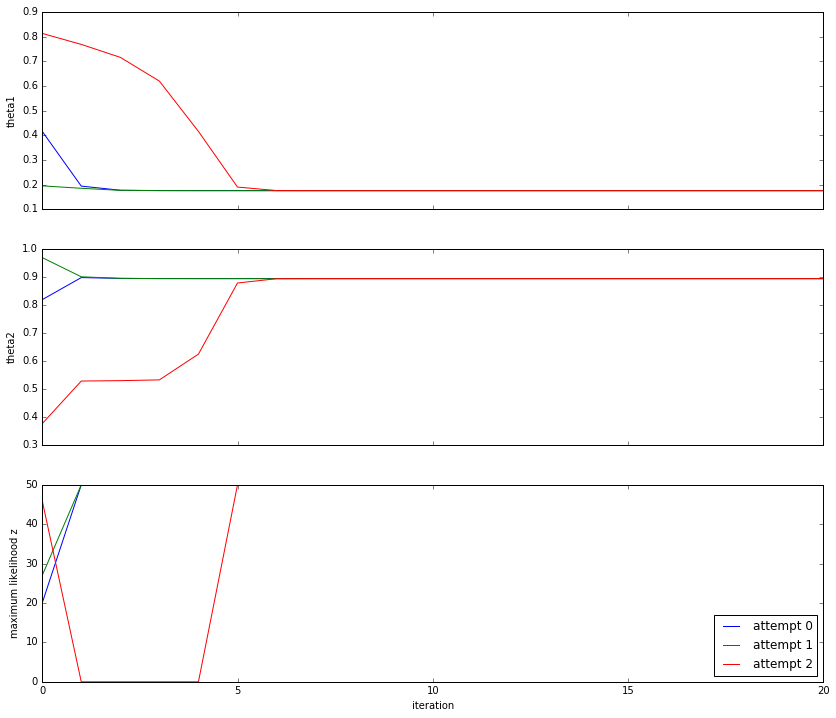

In [141]:
L = 100
z = 50
t1 = 0.1
t2 = 0.9
X = np.append(np.random.binomial(1, p=t1, size=z), np.random.binomial(1, p=t2, size=L-z))
res = []
for i in range(3):
    res += [EM(X)]

fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
plt1.set_ylabel("theta1")
for i in range(3):
    plt1.plot(res[i][1])
plt2.set_ylabel("theta2")
for i in range(3):
    plt2.plot(res[i][2])
plt3.set_xlabel("iteration")
plt3.set_ylabel("maximum likelihood z")
for i in range(3):
    plt3.plot(np.array(res[i][0]).argmax(axis=1), label="attempt " + str(i))
plt3.legend(loc=4)
plt.show()

4\. **(0.5 балла)** Какой функционал оптимизирует ЕМ-алгоритм? Постройте график зависимости этого функционала от номера итерации ЕМ-алгоритма. Ведёт ли эта величина себя монотонно?

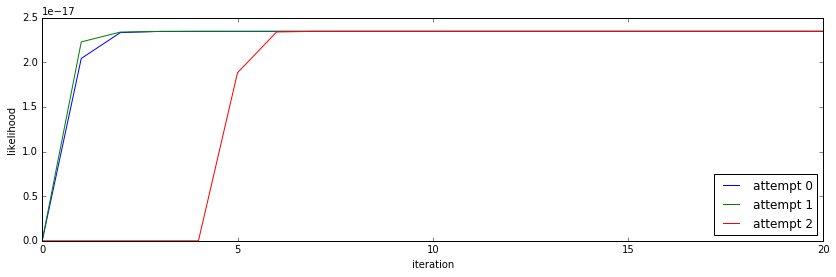

In [142]:
fig, plt1 = plt.subplots(1, 1, figsize=(14, 4))
plt1.set_xlabel("iteration")
plt1.set_ylabel("likelihood")
for i in range(3):
    plt1.plot(res[i][3], label="attempt " + str(i))
plt1.legend(loc=4)
plt.show()

Ну на графике выше всё монотонно...
Но как видно будет в следующем эксперименте, это вовсе не обязательно. Дело в том, что EM - это не совсем покоординатный спуск, для покоординатного спуска нужно было бы работать не с распределением $z$, а на каждой итерации вычислять её самое правдоподобное значение ("спускаться по этой переменной"). Тогда монотонность была бы гарантирована. В текущем же случае, максимизируется оценка снизу на наш функционал, и гарантий монотонности такая стратегия не даёт.

5\. **(0.5 балла)** Повторите эксперимент аналогично п.3 1000 раз для $\theta_1 = 0.49$, $\theta_2 = 0.51, z=500, l=550$. Оцените RMSE для между истинным значением и оценками, полученными в результате экспериментов, для $\theta_1, \theta_2, z$, а также постройте гистограмму полученных в результате экспериментов остатков для этих величин.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


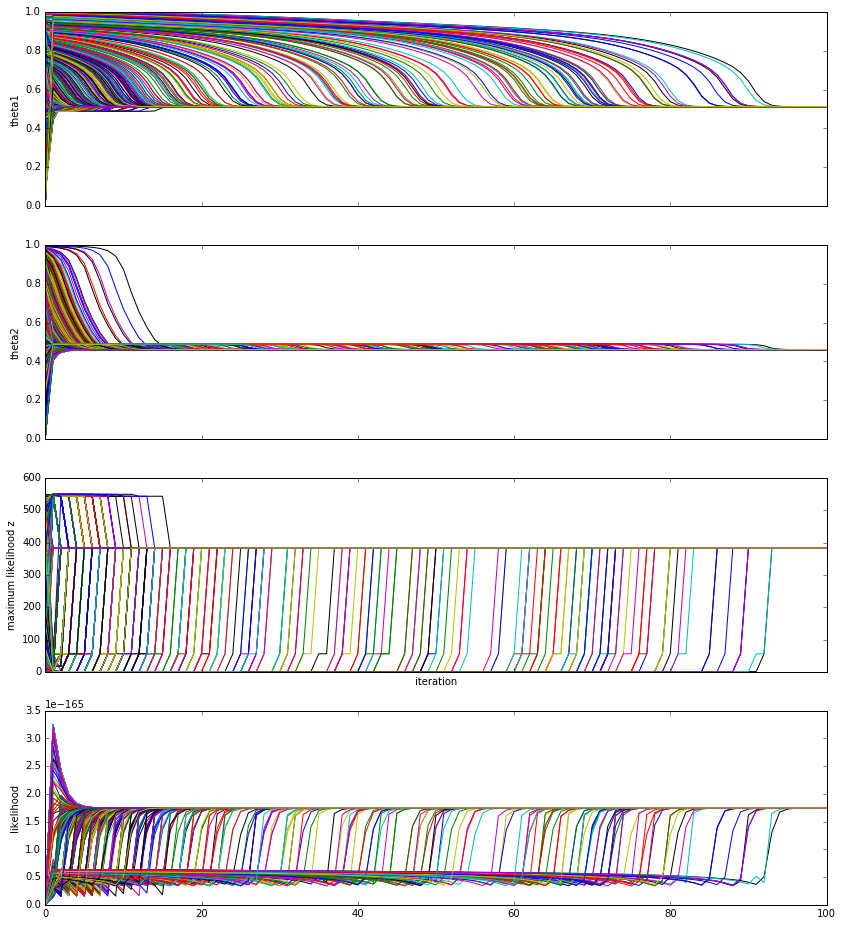

In [144]:
L = 550
z = 500
t1 = 0.49
t2 = 0.51
X = np.append(np.random.binomial(1, p=t1, size=z), np.random.binomial(1, p=t2, size=L-z))
res = []
for i in range(1000):
    res += [EM(X, 100)]

fig, (plt1, plt2, plt3, plt4) = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
plt1.set_ylabel("theta1")
for i in range(1000):
    plt1.plot(res[i][1])
plt2.set_ylabel("theta2")
for i in range(1000):
    plt2.plot(res[i][2])
plt3.set_xlabel("iteration")
plt3.set_ylabel("maximum likelihood z")
for i in range(1000):
    plt3.plot(np.array(res[i][0]).argmax(axis=1))
plt4.set_ylabel("likelihood")
for i in range(1000):
    plt4.plot(res[i][3])
plt.show()

In [146]:
print("RMSE t1: ", ((np.array([res[i][1][-1] for i in range(1000)]) - t1)**2).mean()**0.5)
print("RMSE t2: ", ((np.array([res[i][2][-1] for i in range(1000)]) - t2)**2).mean()**0.5)

z_differences = np.array([np.array(res[i][0]).argmax(axis=1)[-1] for i in range(1000)]) - z
print("RMSE z: ", (z_differences**2).mean()**0.5)

RMSE t1:  0.0225844341
RMSE t2:  0.0491828901884
RMSE z:  117.0


Есть подозрение, что мне "повезло" и все 1000 раз алгоритм сошёлся в одну точку

In [153]:
(z_differences != 117).any()

True

Нда, действительно. Смешно, что "не в ту" точку он сходится, z неверен на 117 отсчётов.

Проведём эксперимент ещё раз, перегенерив выборку.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


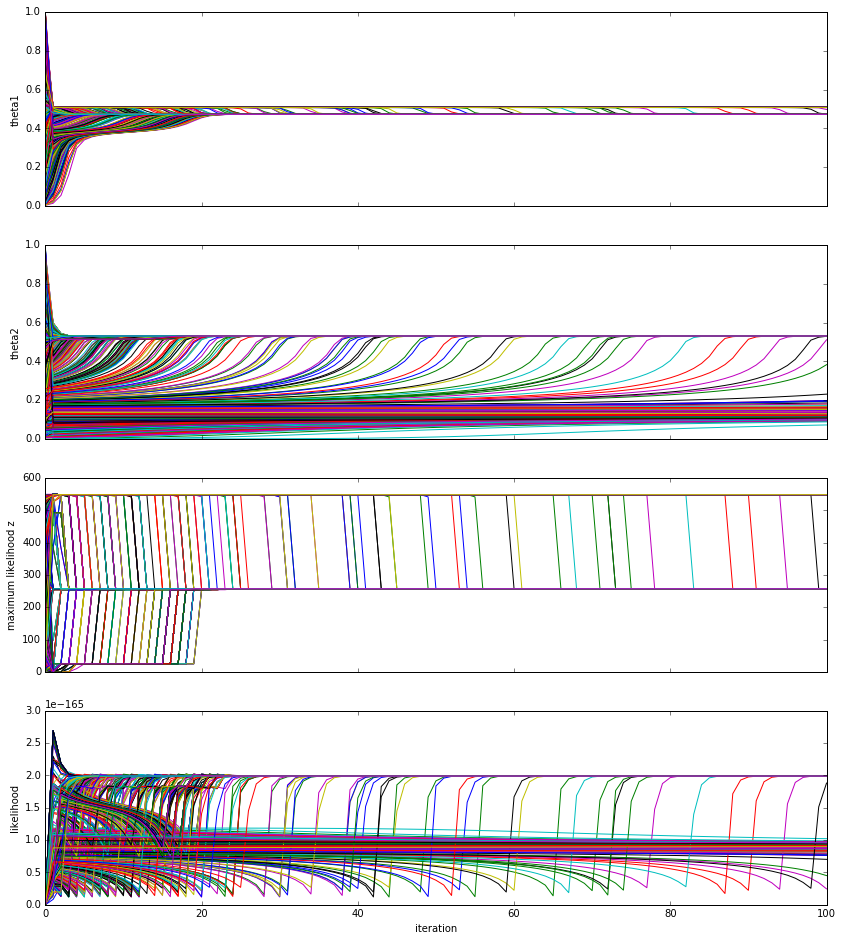

In [173]:
L = 550
z = 500
t1 = 0.49
t2 = 0.51
X = np.append(np.random.binomial(1, p=t1, size=z), np.random.binomial(1, p=t2, size=L-z))
res = []
for i in range(1000):
    res += [EM(X, 100)]

fig, (plt1, plt2, plt3, plt4) = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
plt1.set_ylabel("theta1")
for i in range(1000):
    plt1.plot(res[i][1])
plt2.set_ylabel("theta2")
for i in range(1000):
    plt2.plot(res[i][2])
plt3.set_ylabel("maximum likelihood z")
for i in range(1000):
    plt3.plot(np.array(res[i][0]).argmax(axis=1))
plt4.set_ylabel("likelihood")
plt4.set_xlabel("iteration")
for i in range(1000):
    plt4.plot(res[i][3])
plt.show()

In [174]:
t1_differences = (np.array([res[i][1][-1] for i in range(1000)]) - t1)
print("RMSE t1: ", (t1_differences**2).mean()**0.5)
t2_differences = (np.array([res[i][2][-1] for i in range(1000)]) - t2)
print("RMSE t2: ", (t2_differences**2).mean()**0.5)
z_differences = np.array([np.array(res[i][0]).argmax(axis=1)[-1] for i in range(1000)]) - z
print("RMSE z: ", (z_differences**2).mean()**0.5)

RMSE t1:  0.0174061234212
RMSE t2:  0.163486094306
RMSE z:  222.138706668


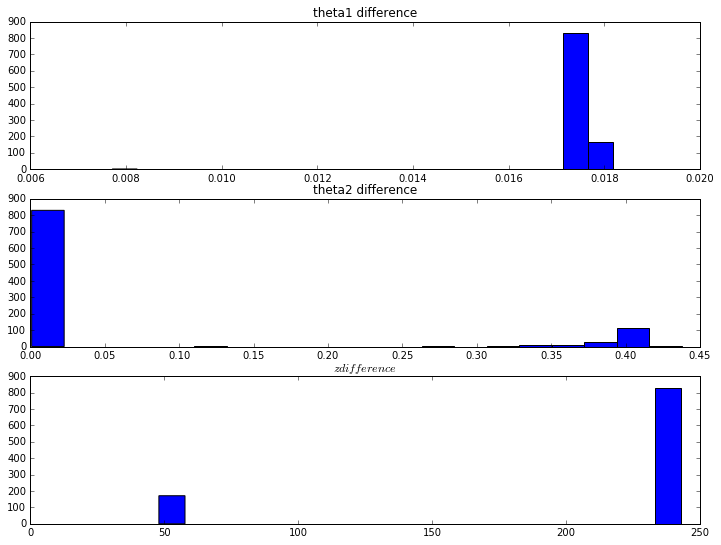

In [357]:
fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(12, 9))
plt1.set_title("theta1 difference")
plt1.hist(abs(t1_differences), 20)
plt2.set_title("theta2 difference")
plt2.hist(abs(t2_differences), 20)
plt3.set_title("$z difference$")
plt3.hist(abs(z_differences), 20)
plt.show()

Более интересный результат. Алгоритм "сходится" в разные точки, а учитывая предложенные параметры это тем более неудивительно. Судя по разбросу theta2, её значение ещё колеблется возле какого-то локального минимума. Возможно, с увеличением числа итераций алгоритм выберется из него и перескочет в более стабильный минимум при z около 250. При этом theta всё равно остаются близкими к 0.5, что означает, что возможно просто так сгенерировалась выборка, что в районе 250-го отсчёта изменение оценки параметра по выборке оказалсь случайно больше 0.02. Кстати, это можно проверить:

In [359]:
X[:250].sum() / 250, X[250:].sum() / 300

(0.46800000000000003, 0.54000000000000004)

Да, действительно, так и есть.

## Смесь нормальных распределений

Пусть данные описываются смесью многомерных нормальных распределений:
$$p(x_i|\Theta) = \sum_{k=1}^K \pi_k p(x_i|\theta_k) = \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k).$$

В рамках данной части задания вам необходимо реализовать ЕМ-алгоритм для нахождения параметров указанного распределения (формулы для данной модели были выведены в материалах [семинара 15](https://github.com/esokolov/ml-course-hse/blob/master/2016-spring/seminars/sem15-EM.pdf)) и применить его для решения задачи классификации на датасете MNIST. Чтобы применение ЕМ-алгоритма к датасету MNIST было осмысленным, мы воспользуемся методом понижения размерности t-SNE.

7\. **(2 балла)** Реализуйте ЕМ-алгоритм для заданной модели в виде функции, параметром которой является наблюдаемая выборка, а возвращаемым значением — итоговые оценки параметров распределения и значения скрытых переменных. В качестве критерия останова можете использовать ограничение количества итераций. Формат входных и выходных данных функции остаётся на ваше усмотрение.

In [309]:
from scipy.stats import multivariate_normal
from scipy.misc import logsumexp
def EM(X, K, iterations=100):
    # Инициализация
    L = len(X)
    z = np.random.uniform(0, 1, (L, K))
    z /= z.sum(axis=1)[:, np.newaxis]
    pi = np.random.uniform(0, 1, K)
    pi / pi.sum()
    
    # Инициализация средних случайными объектами из выборки (фокусы от Китова)
    means = X[np.random.choice(range(L), K)]
    
    # Случайную матрицу домножаем на себя транспонированную, чтобы получить неотрицательно определённую
    def random_cov():
        A = np.random.uniform(0, 1, (X.shape[1], X.shape[1]))
        return A.dot(A.T)
    covariations = np.array([random_cov() for i in range(K)])
       
    for iteration in range(iterations):
        # Во избежание проблем с точностью пользуемся логарифмами и хитрой функцией logsumexp (фокусы от Януша)
        for k in range(K):
            z[:, k] = math.log(pi[k]) + multivariate_normal.logpdf(X, means[k], covariations[k])
        z -= logsumexp(z, axis=1, keepdims=True)
        z = np.exp(z)
               
        pi = z.mean(axis=0)
        means = (z.T.dot(X) / pi[:, np.newaxis]) / L
        
        # ковариацию считаем аккуратно и в лоб, а также применяем регуляризацию (фокусы от Кропотова)
        covariations = np.array([np.array([z[i, k] * ((X[i] - means[k])[:, np.newaxis].dot([X[i] - means[k]])) 
                   for i in range(L)]).sum(axis=0) / (pi[k] * L) + 0.00000001 * np.eye(X.shape[1]) for k in range(K)])
    
    return z, pi, means, covariations

8\. **(1 балл)** Загрузите признаковые описания и значения целевой переменной для 2000 случайных объектов из обучающей выборки датасета [MNIST](http://yann.lecun.com/exdb/mnist/) и сохраните их в соответствующие переменные.

_Примечание: далее было обнаружено, что в задание был введён фикс, где также просилось качество на каком-нибудь контроле. В качестве контроля были взяты ещё 2000 случайных объектов, t-SNE делался на всём множестве объектов и из теста, и из обучения_

In [345]:
import sklearn.datasets
dataset = sklearn.datasets.fetch_mldata("MNIST original")
target = dataset.target.astype(int)
data = dataset.data.astype(float)

args = np.arange(60000)
np.random.shuffle(args)
data = data[args]
target = target[args]

train = data[:2000]
ans = target[:2000]

test = data[2000:4000]
test_ans = target[2000:4000]

9\. **(0.5 балла)** Визуализируйте полученную выборку на плоскости при помощи t-SNE, используя различные цвета для объектов различных классов.

In [346]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
tr = model.fit_transform(train)

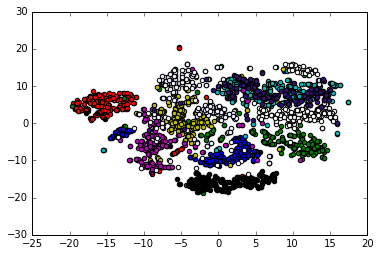

In [347]:
for digit, color in zip(np.unique(ans), ['r', 'b', 'g', 'y', 'c', 'm', 'k', 'w', '#eeefff', '#331177']):
    plt.scatter(tr[ans == digit][:, 0], tr[ans == digit][:, 1], c=color)

10\. **(0.5 балла)** Для выборки из п. 8 понизьте количество признаков до 3 при помощи t-SNE и примените функцию из п. 7 для разделения выборки на $K=10$ компонент.

In [348]:
from sklearn.manifold import TSNE
model3 = TSNE(n_components=3)
tr = model3.fit_transform(np.vstack([train, test]))
tr, test = tr[:2000], tr[2000:]

In [349]:
K = 10
z, pi, means, covariations = EM(tr, K)

In [350]:
hard_z = (z == z.max(axis=1, keepdims=True)).astype(bool)

Полученное разделение выборки на компоненты можно использовать для построения классификатора, предсказывающего изображенную цифру. Для этого будем считать прогнозом для всех объектов $k$-ой компоненты самую частую истинную метку среди объектов этой компоненты:

$$a(x_i) = \arg \max_{k \in \{1, \dots, 10\}} \sum_{j=1}^l [z_j = z_i] [y_j = k],$$

где $z_i$ — вектор скрытых переменных для объекта выборки $x_i$.

11\. **(0.5 балла)** Выведите значение accuracy на используемой выборке для описанного выше способа построения прогнозов на объектах и истинной разметки выборки.

In [351]:
# ответы для попадания в каждый из кластеров
answers = np.array([np.bincount(ans[hard_z[:, k]]).argmax() for k in range(K)])
print("cluster answers: ", answers)

accuracy = (answers[z.argmax(axis=1)] == ans).sum() / 2000
print("Accuracy: ", accuracy)

cluster answers:  [1 2 8 6 3 0 2 1 3 7]
Accuracy:  0.54


12\. **(1 балл)** Постройте график зависимости значения accuracy на используемой выборке для описанного выше способа построения прогнозов на объектах и истинной разметки выборки от числа компонент $K$, фигурирующего в ЕМ-алгоритме.

In [354]:
K_range = np.arange(3, 40)
Accuracy = []
Test_Accuracy = []
for K in K_range:
    z, pi, means, covariations = EM(tr, K)
    
    hard_z = (z == z.max(axis=1, keepdims=True)).astype(bool)
    answers = np.array([np.bincount(ans[hard_z[:, k]]).argmax() for k in range(K)])
    Accuracy.append((answers[z.argmax(axis=1)] == ans).sum() / 2000)
    
    # можно сказать, predict-функция EM-алгоритма
    for k in range(K):
        z[:, k] = multivariate_normal.logpdf(test, means[k], covariations[k])   
    
    Test_Accuracy.append((answers[z.argmax(axis=1)] == test_ans).sum() / 2000)    
    print('|', end='')

|||||||||||||||||||||||||||||||||||||

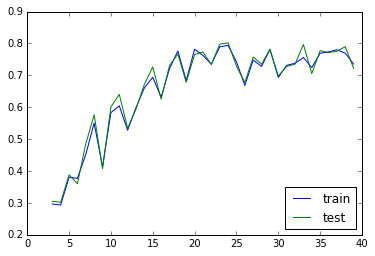

In [355]:
plt.plot(K_range, Accuracy, label="train")
plt.plot(K_range, Test_Accuracy, label="test")
plt.legend(loc=4)

Стоит отметить, что если выбрать K = 2000, то по идее оптимальный классификатор выдаст на обучении идеальное качество, ну а на тесте, конечно, низкое. Логично, что нужно, видимо, брать чуть больше 10 компонент, поскольку иначе эти 10 компонент покрывают не все наши 10 классов. Возможно даже стоит увеличивать K до тех пор, пока в качестве ответа алгоритм не начнёт выдавать все 10 различных вариантов ответа. С учётом того, что качество сильно колеблется от запуска к запуску (я использовал 100 итераций, однако не усреднял по нескольким запускам), по графику видно, что где-то с 17-18-ой итерации потенциального улучшения уже не намечается. Также видно, что 40 итераций недостаточно, чтобы переобучиться, что означает, что в целом число компонент можно выбирать и больше, чем число классов, опираясь на размер выборки. Даже интересно, насколько алгоритм в получившейся здесь постановке похож на kNN?..

Вставьте одну из ваших любимых цитат преподавателей:

\- Вы на мои лекции ходили? Конечно, не ходили! Вам понравилось? Очень понравилось!
\*ставит зачёт всей группе\*
                                          - Денисов Д.В.